# Black Skimmer Occurrence Records Summary
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
%cd ..
import repo_functions as functions

/Users/nmtarr/Code/occurrence-records-wrangler


### Set Variables
Fill out stuff in this cell.

In [2]:
species_id = 'bblskx0'
summary_name = 'Skimmer'

gbif_req_id = 'GBIFr19'
gbif_filter_id = 'GBIFf8'
workDir = '/Users/nmtarr/Documents/NCBA/Data/'
codeDir = '/Users/nmtarr/Code/occurrence-records-wrangler/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 8046
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + species_id + gbif_req_id + gbif_filter_id + '.sqlite'

print("Notebook run " + str(t1))

Notebook run 2019-10-17 11:46:15.555149


In [3]:
connjup = sqlite3.connect(codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

# Species Concept
Display information on the species from the parameters.sqlite database.

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '',
 'common_name': 'black skimmer',
 'detection_distance_meters': 200,
 'ebird_id': None,
 'end_year': None,
 'error_tolerance': 20,
 'fws_id': '',
 'gap_id': 'bblskx',
 'gbif_id': '2481209',
 'geometry': None,
 'itis_tsn': '554447',
 'migratory': '1',
 'notes': None,
 'pad': 1,
 'scientific_name': 'rynchops niger',
 'species_id': 'bblskx0',
 'start_year': None,
 'wintering_months': ''}


## Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                                                          GBIFr19
source                                                                 GBIF
lat_range                                                              None
lon_range                                                              None
years_range                                                       2015,2020
months_range                                                           1,12
geoissue                                                              False
coordinate                                                             True
country                                                                None
geometry        POLYGON ((-84.48078517214034 34.91735591277285, -84.4181...
continent                                                              None
creator                                                             N. Tarr
notes           Parameterized for NC Bird Atlas efforts.  Filterd

Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                                          GBIFf8
dataset                                                                              GBIF
collection_codes_omit                                                                None
institutions_omit                                                                    None
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                          10000
bases_omit                                            PRESERVED_SPECIMEN, FOSSIL_SPECIMEN
protocols_omit                                                                       None
sampling_protocols_omit                                                              None
issues_omit                   GEODETIC_DATUM_INVALID, INDIVIDUAL_COUNT_INVALID, MULTIM...
duplicates_OK                                                           

### Filter set justification
**default_coord_uncertainty**: Many eBird records should be returned and the locational uncertainty could be near 5 miles (8046 m) due to the inclusion of traveling counts.

**years_range**: I included the last 5 years since bird atlases run 3 to 5 years.

**months_range**: Included all months for now in order to see what is returned.  It may be best to limit to certain months eventually.

**geoissue**: Errors in location are too problematic to include.

**coordinate**: Use of records in maps and spatial queries requires that records have x,y coordinates.

**continent**: This parameter is not useful and thus left blank.
 
**geometry**: Limits download to within 10km of NC, as that is the area of interest for NCBA.

**collection_codes_omit**: For now, interested in what comes back.

**institutions_omit**: For now, interested in what comes back.

**has_coordinate_uncertainty**: This parameter isn't useful because of vast majority not having a value.

**max_coordinate_uncertainty**: Extremely high uncertainty isn't helpful, but moderately high uncertainty will be dealt with in the spatial comparison process.

**bases_omit**: Fossils and preserved specimens wouldn't correspond to the questions a bird atlas seeks to answer.

**protocols_omit**: For now, interested in what comes back.

**sampling_protocols_omit**: For now, interested in what comes back.

**issues_omit**: Omitting any issues that we have identified that are undesirable.

**duplicates:** Records with the same date, time, latitudes, and longitudes are suspicious.  The default, hard-coded rule for handling duplicates is to keep the one with the highest count of individuals.

In [7]:
functions.retrieve_gbif_occurrences(codeDir, species_id, inDir, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, SRID_dict, outDir, summary_name)

SPATIALITE_SECURITY set to relaxed
Created occurrence db: 0:00:00.194443
Downloaded records: 0:01:04.355289
	4787 records exist with the request parameters
Created summary table of request results: 0:03:28.097791
Performed post-request filtering: 0:00:00.207842
Summarized results of filtering: 0:00:00.368743
Performed post-request filtering: 0:00:16.048708
Removed duplicates: 0:00:00.061086
	1515 duplicates were deleted
Buffered points: 0:00:02.320353
Exported maps: 0:00:00.546935

Records saved in /Users/nmtarr/Documents/NCBA/Data/Outputs/bblskx0GBIFr19GBIFf8.sqlite


### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [8]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

3249 records


### Are there duplicate records left?
Duplicates based on latitude, longitude, and date-time should of been removed, with the record with the highest individualCount retained.

In [9]:
dups0 = curs_occ.execute("""SELECT count(occ_id) FROM occurrences WHERE occ_id NOT IN (SELECT occ_id FROM occurrences GROUP BY latitude, longitude, occurrenceDate HAVING max(IndividualCount));""").fetchall()
print(str(dups0[0][0]) + ' duplicate records were duplicates based on xy coordinate and date-time')

0 duplicate records were duplicates based on xy coordinate and date-time


# Institutions
#### Pre-filters

In [10]:
institutions = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'institutions';").fetchall()
for x in institutions:
    print(x[0] + " ({0})".format(x[1]))

iNaturalist (25)
CLO (4758)
naturgucker (2)
unknown (2)


#### Post-filter

In [11]:
institutions = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'institutions' AND step = 'filter';").fetchone()[0]
institutions = institutions.replace('[', '').strip().replace(']', '').replace("'", "")
institutions = institutions.split(',')
for ins in institutions:
    print(ins.strip())

naturgucker
iNaturalist
UNKNOWN
CLO


# Collections
#### Pre-filters

In [12]:
collections = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'collections';").fetchall()
for x in collections:
    print(x[0] + " ({0})".format(x[1]))

Observations (25)
EBIRD (4702)
EBIRD_GBBC (3)
EBIRD_QC (6)
naturgucker (2)
EBIRD_CAN (12)
EBIRD_VA (12)
EBIRD_PA (2)
EBIRD_PNW (19)
EBIRD_WI (1)
EBIRD_VINS (1)
Bird sounds (2)


#### Post-filters

In [13]:
collections = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'collections' AND step = 'filter';").fetchone()[0]
collections = collections.replace('[', '').strip().replace(']', '').replace("'", "")
collections = collections.split(',')
for colls in collections:
    print(colls.strip())

EBIRD_QC
EBIRD
EBIRD_GBBC
naturgucker
EBIRD_PNW
EBIRD_PA
Bird sounds
EBIRD_WI
EBIRD_VA
EBIRD_VINS
EBIRD_CAN
Observations


# Bases
#### Pre-filter

In [14]:
bases = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'bases';").fetchall()
for x in bases:
    print(x[0] + " ({0})".format(x[1]))

HUMAN_OBSERVATION (4787)


#### Post-filters

In [15]:
bases = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'bases' AND step = 'filter';").fetchone()[0]
bases = bases.replace('[', '').strip().replace(']', '').replace("'", "")
bases = bases.split(",")
for bas in bases:
    print(bas.strip())

HUMAN_OBSERVATION


# Protocols
#### Pre-filters

In [16]:
protocols = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'protocols';").fetchall()
for x in protocols:
    print(x[0] + " ({0})".format(x[1]))

DWC_ARCHIVE (4785)
BIOCASE (2)


#### Post-filters

In [17]:
protos = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'protocols' AND step = 'filter';").fetchall()[0]
for pro in protos:
    pro = pro.replace('[', '').strip().replace(']', '').replace("'", "")
    print(pro)

DWC_ARCHIVE, BIOCASE


# Issues
#### Pre-filters

In [18]:
issues = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'issues';").fetchall()
for x in issues:
    print(x[0] + " ({0})".format(x[1]))

COORDINATE_ROUNDED (3952)
GEODETIC_DATUM_ASSUMED_WGS84 (28)


#### Post-filters

In [19]:
issues = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'issues' AND step = 'filter';").fetchone()[0]
issues = issues.replace('[', '').strip().replace(']', '').replace("'", "")
issues = issues.split(',')
for iss in issues:
    print(iss.strip())

GEODETIC_DATUM_ASSUMED_WGS84
COORDINATE_ROUNDED


# Descriptions of filtered records

### Locations

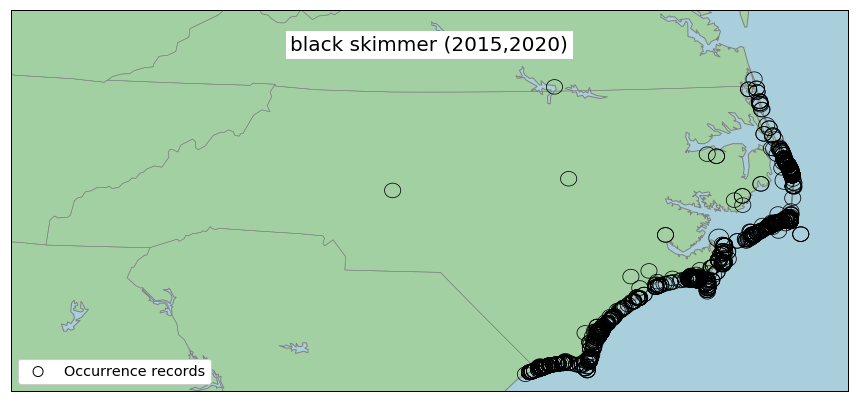

In [20]:
shp1 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
map_these=[shp1]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons_NC(map_these=map_these, title=title)

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

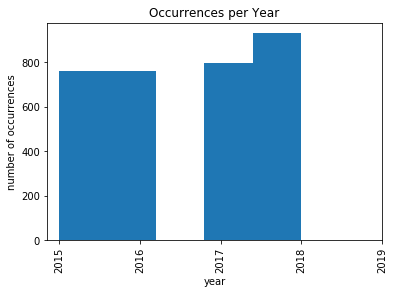

In [21]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

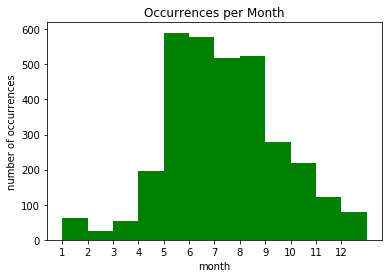

In [22]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

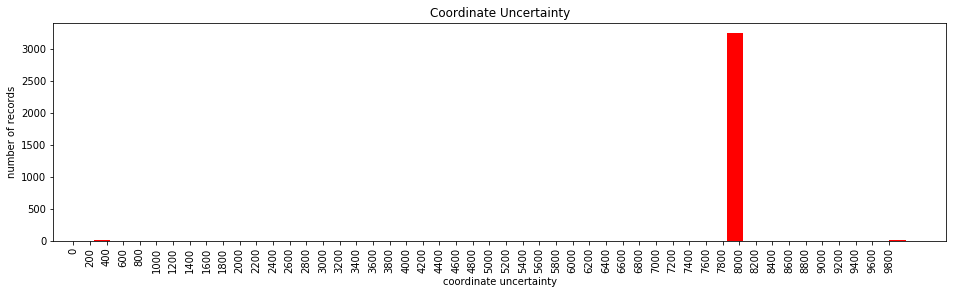

In [23]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

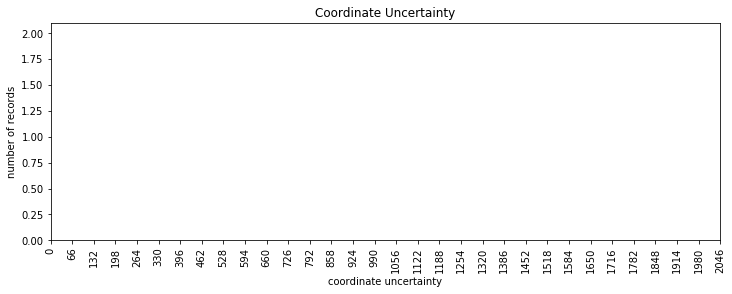

In [24]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### Geodetic datums present

In [25]:
datums = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'datums' AND step = 'filter';").fetchone()[0]
datums = datums.replace('[', '').strip().replace(']', '').replace("'", "")
datums = datums.split()
for datum in datums:
    print(datum)

WGS84


### Establishment means reported

In [26]:
establishment = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

### Identification qualifiers included

In [27]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM record_attributes WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

### Remarks included

In [28]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
#remarks = remarks.replace('[', '').strip().replace(']', '').replace("'", "")
#remarks = remarks.split(',')
if len(remarks) <= 20:
    for rem in remarks:
        if rem[0][0:1] == ';':
            print(rem[0][2:])
        else:
            print(rem[0])
else:
    print("More than 20 remarks, consult the occurrence database.")

More than 20 remarks, consult the occurrence database.


### Sources

In [29]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### Attributes returned for the records in the request (pre-filters)

In [30]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ, index_col='index')
fields_summary.index.name = 'field'
print(fields_summary)

                                      included(n)  populated(n)
field                                                          
acceptedScientificName                       4787          4787
acceptedTaxonKey                             4787          4787
associatedTaxa                                  2             2
basisOfRecord                                4787          4787
behavior                                        2             2
catalogNumber                                4787          4787
class                                        4787          4787
classKey                                     4787          4787
collectionCode                               4787          4787
coordinateUncertaintyInMeters                  27            27
country                                      4787          4787
countryCode                                  4787          4787
county                                       4758          4758
crawlId                                 

### Runtime

In [31]:
t2 = datetime.now()
print(t2 - t1)

0:05:01.440066
